In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from typing import Union
import os
import gc
import numpy as np
import mayavi.mlab as mlab

def create_figure(celestial_objects:list, var:int, figure_name:str=None)->None:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    for i in range(len(celestial_objects)):
        body = celestial_objects[i]
        trajectory = np.array(body.trajectory[:var + 1])
        ax.plot(trajectory[:, 1], trajectory[:, 2], trajectory[:, 3], label=body.name, color=body.color)
        ax.plot(trajectory[-1, 1], trajectory[-1, 2], trajectory[-1, 3], "o", color=body.color)
    ax.legend(loc='center left', bbox_to_anchor=(1.09, 0.35))
    plt.savefig(f"temp/data_{int(var/10):03d}.png", dpi=200)
    plt.show()
    plt.close(fig)
    gc.collect()

class Visualize():
    """A class for Visualizing the trajectory of the orbits of the N-Bodies Simulated

    Attributes:
        celestial_objects (object): An object belonging to Simulation Classes containing the simulation results for 
                                    the orbital trajectory.
        visual_type (str): A user input to determine whether to render an animation, or a simple scientific plot
        save_fig (bool): A user input to determine whether to save the trajectory visualization. Defaults to False
        figure_name (str): The name for the figure to be saved. Defaults to None
        ani_name (str): The name for the animation to be saved. Defaults to None
    """
    def __init__(self, celestial_objects:list, visualization_type:str="scientific", save_figure:bool=False,
                 figure_name:str=None) -> None:
        """Constructor for the Visualization class

        Args:
            celestial_objects (object): An object of the simulation class containing the trajectory of the bodies
            visualization_type (str, optional): Type of Visualization (scientific or animation). Defaults to "scientific".
            save_figure (bool, optional): A value to determine whether to save the visualization or not. Defaults to False.
            figure_name (str, optional): Name of the file that will hold the visualization if save_figure is True. Defaults to None.

        Raises:
            TypeError: Raised when input values do not belong to the required datatypes
            ValueError: Raised when visualization_type does not belong to the allowed value.
        """
        try:
            assert isinstance(celestial_objects, object), "The celestial_objects needs to be a list of objects for visualization"
            assert isinstance(visualization_type, str), "The visualization_type needs to be a string"
            assert isinstance(save_figure, bool), "The attribute save_figure must be a boolean"
            assert isinstance(figure_name, str), "The figure_name must be a string"
        except AssertionError:
            raise TypeError
        try:
            accepted_choices = ["scientific", "animation"]
            assert (visualization_type.lower() in accepted_choices), "The visualization type must be either scientific/animation"
        except AssertionError:
            raise ValueError
        self.celestial_objects = celestial_objects
        self.visual_type = visualization_type
        self.save_fig = save_figure
        self.ani_name = None
        if figure_name is not None and visualization_type == "scientific":
            self.figure_name = figure_name + ".jpeg"
            self.ani_name = figure_name + ".mp4"
        else:
            if figure_name is not None:
                self.ani_name = figure_name + ".gif"

    def __create_matplotlib_animation(self):
        """Private method of the Visualization class that generates an animation of the trajectory of the bodies.	
        """
        try:
            os.mkdir("temp")
        except:
            pass
        self.n_total = int(len(self.celestial_objects[0].trajectory) / 10)
        for j in range(0, self.n_total):
            var = j * 10
            create_figure(self.celestial_objects, var, figure_name="temp/data_" + str(j))
        #os.system(f"ffmpeg -r 30 -i temp/data_%d.png -vcodec mpeg4 -y {self.ani_name}")
        #os.rmdir("temp")
            
    
    def __scientific_plot(self, animate:bool)->None:
        """Private method of the Visualization class that generates a maplotlib plot of the trajectory of the bodies.

        Raises:
            ValueError: When no trajectory for the celestial objects are found
        """
        try:
            for body in self.celestial_objects:
                assert body.trajectory!=[], f"Empty trajectory found for {body.name}. Run Simulations first"
        except AssertionError:
            raise ValueError
        if animate:
            self.__create_matplotlib_animation()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        i = 1
        for body in self.celestial_objects:
            trajectory = np.array(body.trajectory)
            if body.object_type != "fragment":
                ax.plot(trajectory[:,1], trajectory[:,2], trajectory[:,3], label=body.name)
            else:
                ax.plot(trajectory[:,1], trajectory[:,2], trajectory[:,3], label=f"fragment{i}")
                i += 1
        ax.legend(loc='center left', bbox_to_anchor=(1.09, 0.35))
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")
        ax.set_zlabel("z [m]")
        if self.save_fig:
            plt.savefig(self.figure_name, dpi=300)
        plt.show()
    
    def __animation(self)->None:
        fig = mlab.figure(size=(1280, 720))
        points = []
        traj = []
        for body in self.celestial_objects:
            spacetime_point = body.trajectory[0]
            if spacetime_point[0] == 0:
                points.append(mlab.points3d(spacetime_point[1], spacetime_point[2], spacetime_point[3], 
                                            scale_factor=body.radius, color=body.color))
                traj.append(mlab.plot3d(spacetime_point[:1,1], spacetime_point[:1,2], spacetime_point[:1,3],
                                        color=body.color))
            else:
                points.append(None)
                traj.append(None)
        
        def update(frame):
            all_points = []
            for i,body in self.celestial_objects:
                spacetime_point = np.array(body.trajectory[frame])
                if spacetime_point[0] == frame:
                    spacetime_trajectory = np.array(body.trajectory)[:frame+1]
                    points[i] = mlab.points3d(spacetime_point[1], spacetime_point[2], spacetime_point[3],
                                            scale_factor=body.radius, color=body.color)
                    traj[i] = mlab.plot3d(spacetime_trajectory[:frame,1], spacetime_trajectory[:frame,2], 
                                          spacetime_trajectory[:frame,3], color=body.color)
                    all_points.append(spacetime_trajectory)
            all_points = np.array(all_points)
            mlab.view(focalpoint=(all_points[:,1].mean(), all_points[:,2].mean(), all_points[:,3].mean()))
        
        def animate():
            for frame in range(self.n_total):
                update(frame)
                mlab.process_ui_events()
                mlab.draw()
                mlab.pause(0.05)
        
        animate()
        mlab.show()
    
    def visualize(self, animate:bool=False, time_interval:Union[float,int]=None)->None:
        """Method of the visualization class that generates the visualization for the trajectories based on the visualization type

        Args:
            animate (bool): Used for scientific visualization and control whether an animation is generated.
            time_interval (float/int, optional): Required on for animations to determine the time interval between each frame. 
                                                Defaults to None.

        Raises:
            ValueError: When the time_interval is not specified for the animation render.
        """
        try:
            assert isinstance(animate, bool), "animate can only be set to True/False"
            #assert (isinstance(time_interval, (float,int)) and self.visual_type == "animation"), "Time Interval cannot be None for Animation Renders"
        except AssertionError:
            raise ValueError
        if self.visual_type == "scientific":
            self.__scientific_plot(animate=animate)
        else:
            self.__animation()

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


In [6]:
class Body():
    def __init__(self, name, trajectory, color, object_type, radius):
        self.name = name
        self.trajectory = trajectory
        self.color = color
        self.object_type = object_type
        self.radius = radius

names = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]
rad = [9.9e8, 2.4397e6, 6.0518e6, 6.371e6, 3.3895e6, 6.9911e7, 5.8232e7, 2.5362e7, 2.4622e7]
color_list = ["yellow", "grey", "white", "blue", "red", "orange", "brown", "cyan", "blue"]
#color_list = [(1,1,0), (0.5,0.5,0.5), (1,1,1), (0,0,1), (1,0,0), (1,0.5,0), (0.5,0.25,0), (0,1,1), (0,0,1)]
obj_list = []
i = 0
for name in names:
    traj = np.loadtxt("{}.txt".format(name))
    traj = list(traj)
    object_type = "star"
    color = color_list[i]
    obj = Body(name, traj, color, object_type, rad[i])
    i += 1
    obj_list.append(obj)

In [7]:
vis = Visualize(obj_list, "scientific", False, "bhs")

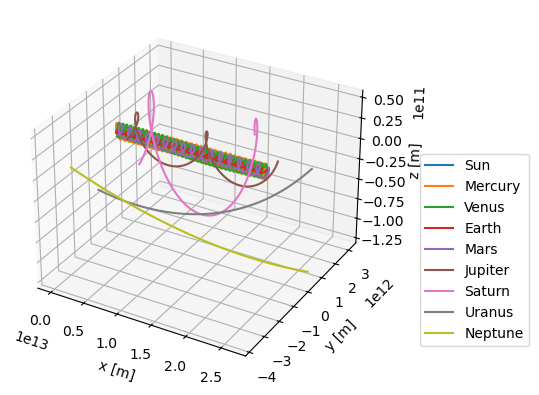

In [8]:
vis.visualize(animate=False)

In [3]:
def animate_trajectories(obj_list, interval=1000):
    mlab.figure(bgcolor=(0, 0, 0), size=(1000, 1000))

    # Create sphere objects for each celestial body
    spheres = []
    lines = []
    for obj in obj_list:
        sphere = mlab.points3d(obj.trajectory[0, 1], obj.trajectory[0, 2], obj.trajectory[0, 3],
                               scale_factor=100*obj.radius, color=obj.color)
        spheres.append(sphere)
        line = mlab.plot3d(obj.trajectory[:, 1], obj.trajectory[:, 2], obj.trajectory[:, 3], color=obj.color)
        lines.append(line)
    
    # Function to update the positions of the spheres
    def update_scene(step):
        for sphere, obj in zip(spheres, obj_list):
            index = step * interval
            if index < len(obj.trajectory):
                t, x, y, z = obj.trajectory[index]
                sphere.mlab_source.set(x=x, y=y, z=z)
                #lines.mlab_source.set(x=obj.trajectory[:index, 1], y=obj.trajectory[:index, 2], z=obj.trajectory[:index, 3])

    # Number of frames for the animation
    n_frames = obj_list[0].trajectory.shape[0] // interval

    # Create the animation
    for i in range(n_frames):
        update_scene(i)
        mlab.process_ui_events()
        mlab.view(azimuth= 45, elevation=90)
        #mlab.savefig(f"frame_{i:04d}.png")
    
    mlab.show()

# Run the animation
animate_trajectories(obj_list, interval=1000)